# Testing notebook

I use this notebook to test and troubleshoot functions I'm working on

### Default imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

### Sample data

In [2]:
x = np.load('./exampledata.npy')
Fs = 1000

# 1. Whitten oscillation detector

In [4]:
from misshapen.nonshape import f_psd, spectral_slope, bandpass_default, _rmv_short_periods

# NOTE: Need a long window size to calculate the slope (because too few samples for a fit if small window)
# BUT: Need a short window size to calculate the spectrogram (or else poor time resolution for oscillation decting)

# Function parameters
f_range = (10,20)
f_slope = ((2,8),(25,35))
filter_fn = bandpass_default
filter_kwargs = {}
percentile_thresh = .95
window_size_slope = int(20*Fs/float(f_range[1]))
window_size_spec = int(7*Fs/float(f_range[1]))

In [5]:
welch_params={'window':'hanning','nperseg':window_size_slope,'noverlap':None}
f, psd = f_psd(x, Fs, 'welch', welch_params=welch_params)

# Calculate slope
f_sampleslope = f[np.logical_or(np.logical_and(f>=f_slope[0][0],f<=f_slope[0][1]),
                               np.logical_and(f>=f_slope[1][0],f<=f_slope[1][1]))]
slope_val, fit_logf, fit_logpower = spectral_slope(f, psd, f_sampleslope = f_sampleslope)

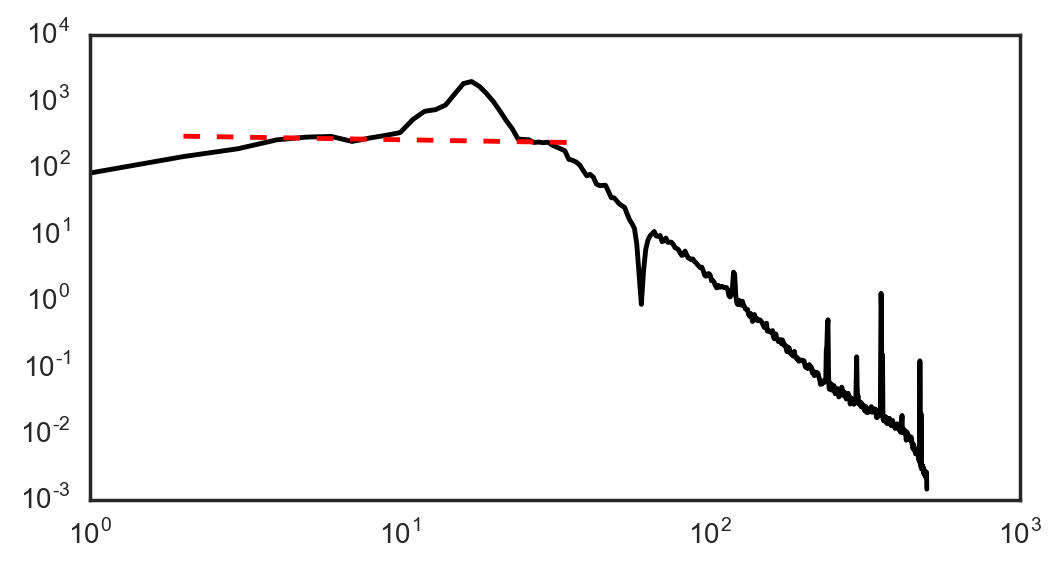

In [6]:
# Confirm slope fit is reasonable
plt.figure(figsize=(6,3))
plt.loglog(f,psd,'k-')
plt.loglog(10**fit_logf, 10**fit_logpower,'r--')

In [7]:
# Intepolate 1/f over the oscillation period
fn_interp = sp.interpolate.interp1d(fit_logf, fit_logpower)
f_osc_log = np.log10(np.arange(f_range[0],f_range[1]+1))
p_interp_log = fn_interp(f_osc_log)

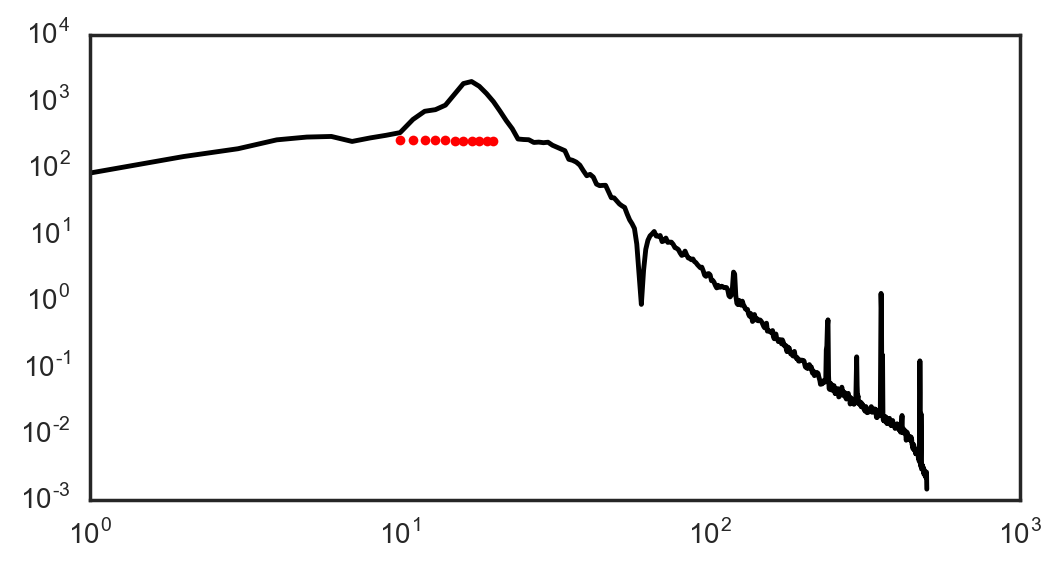

In [8]:
# Confirm slope fit over oscillation
plt.figure(figsize=(6,3))
plt.loglog(f,psd,'k-')
plt.loglog(10**f_osc_log, 10**p_interp_log,'r.')

In [9]:
# Calculate power threshold
meanpower = 10**p_interp_log
powthresh = np.mean(sp.stats.chi2.ppf(percentile_thresh,2)*meanpower/2.)
print powthresh

774.295635872


In [10]:
# Calculate spectrogram and power time series
# Note that these spectral statistics are calculated using the 'psd' mode common to both 'spectrogram' and 'welch' in scipy.signal
f, t_spec, x_spec_pre = sp.signal.spectrogram(x, fs=Fs, window='hanning', nperseg=window_size_spec, noverlap=window_size_spec-1, mode='psd')

In [11]:
# pad spectrogram with 0s to match the original time series
t = np.arange(0,len(x)/float(Fs),1/float(Fs))
x_spec = np.zeros((len(f),len(t)))
tidx_start = np.where(np.abs(t-t_spec[0])<1/float(10*Fs))[0][0]
x_spec[:,tidx_start:tidx_start+len(t_spec)]=x_spec_pre

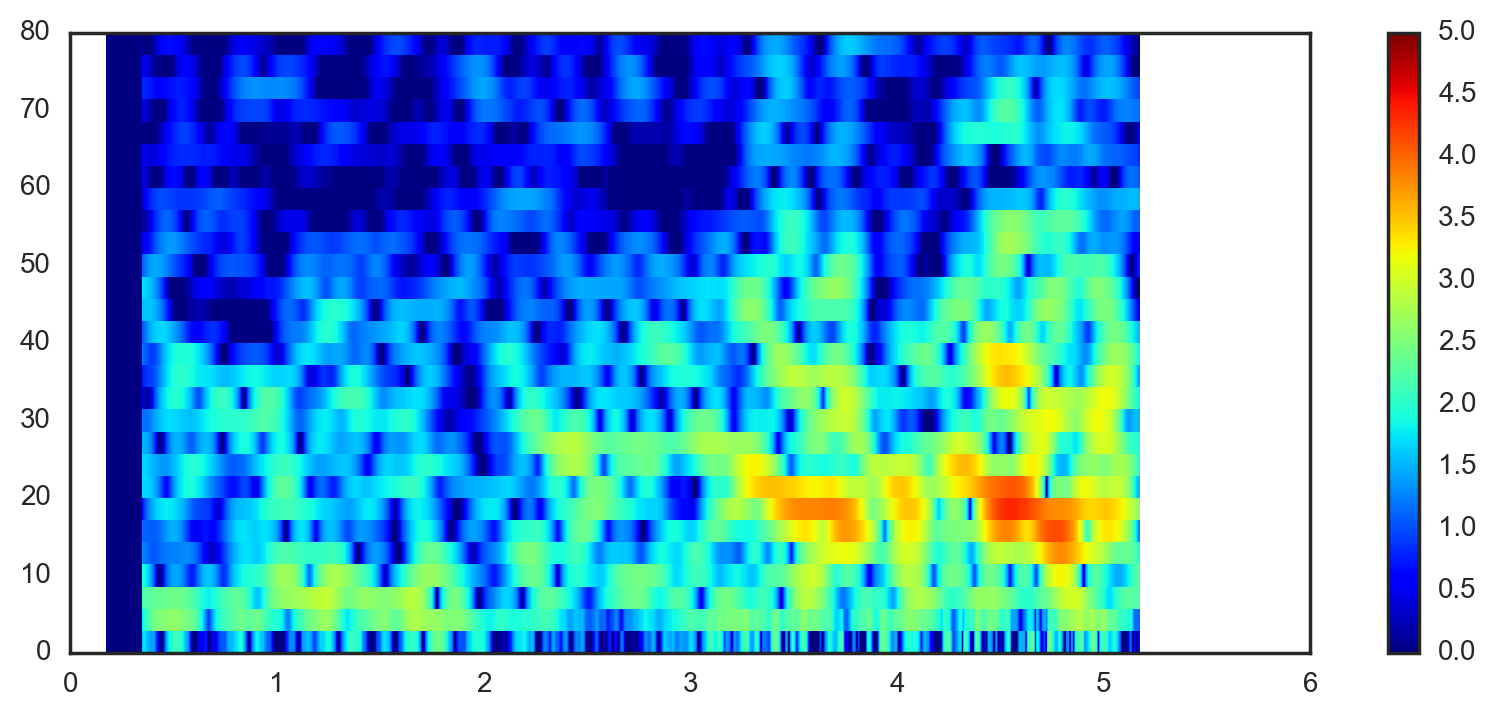

In [12]:
from matplotlib import cm
x_logspec = np.log10(x_spec)
tspec_plot = t_spec[:5000]
x_logspec_plot = x_logspec[:,:5000]
x_mesh, y_mesh = np.meshgrid(tspec_plot, f)
plt.figure(figsize=(10,4))
plt.pcolormesh(x_mesh, y_mesh, x_logspec_plot, cmap=cm.jet, vmin=0, vmax=5)
plt.ylim((0,80))
plt.colorbar()

In [13]:
# Calculate instantaneous power
fidx_band = np.where(np.logical_and(f>=f_range[0],f<=f_range[1]))[0]
x_bandpow = np.mean(x_spec[fidx_band],axis=0)

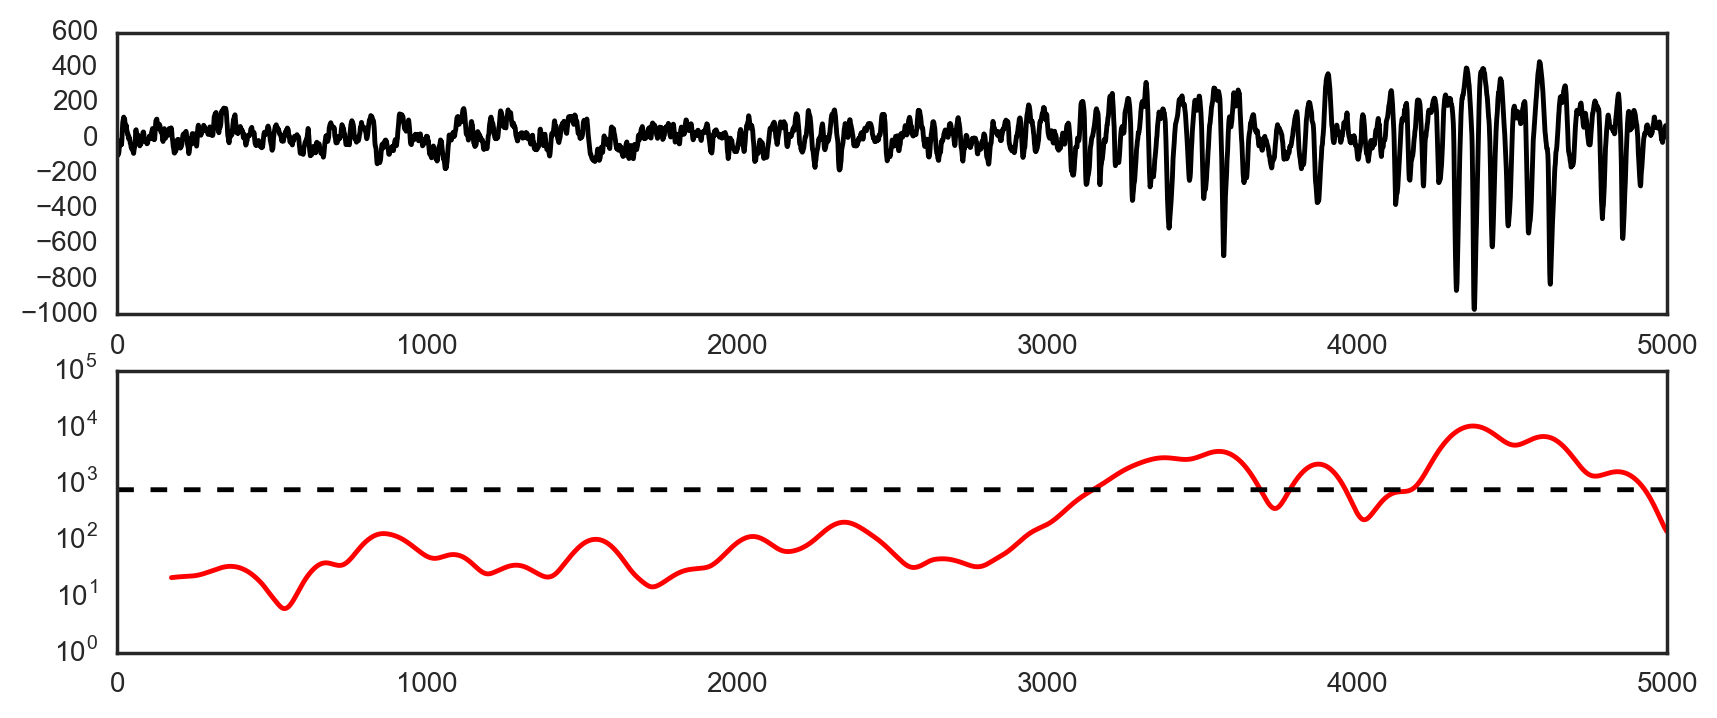

In [15]:
tmax = np.min((len(x_bandpow),5000))
samp_plt=range(0, tmax)
plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.plot(x[samp_plt],'k')
plt.subplot(2,1,2)
plt.semilogy(x_bandpow[samp_plt],'r')
plt.semilogy(range(tmax),[powthresh]*tmax,'k--')

In [17]:
# Threshold power time series to find time periods of an oscillation
from misshapen import nonshape
isosc = x_bandpow > powthresh

# Reject oscillations that are too short
min_burst_length = int(np.ceil(3 * Fs / float(f_range[1]))) # 3 cycles of fastest freq
isosc_noshort, osc_starts, osc_ends = nonshape._rmv_short_periods_whitten(isosc, min_burst_length)

(-0.1, 1.1)

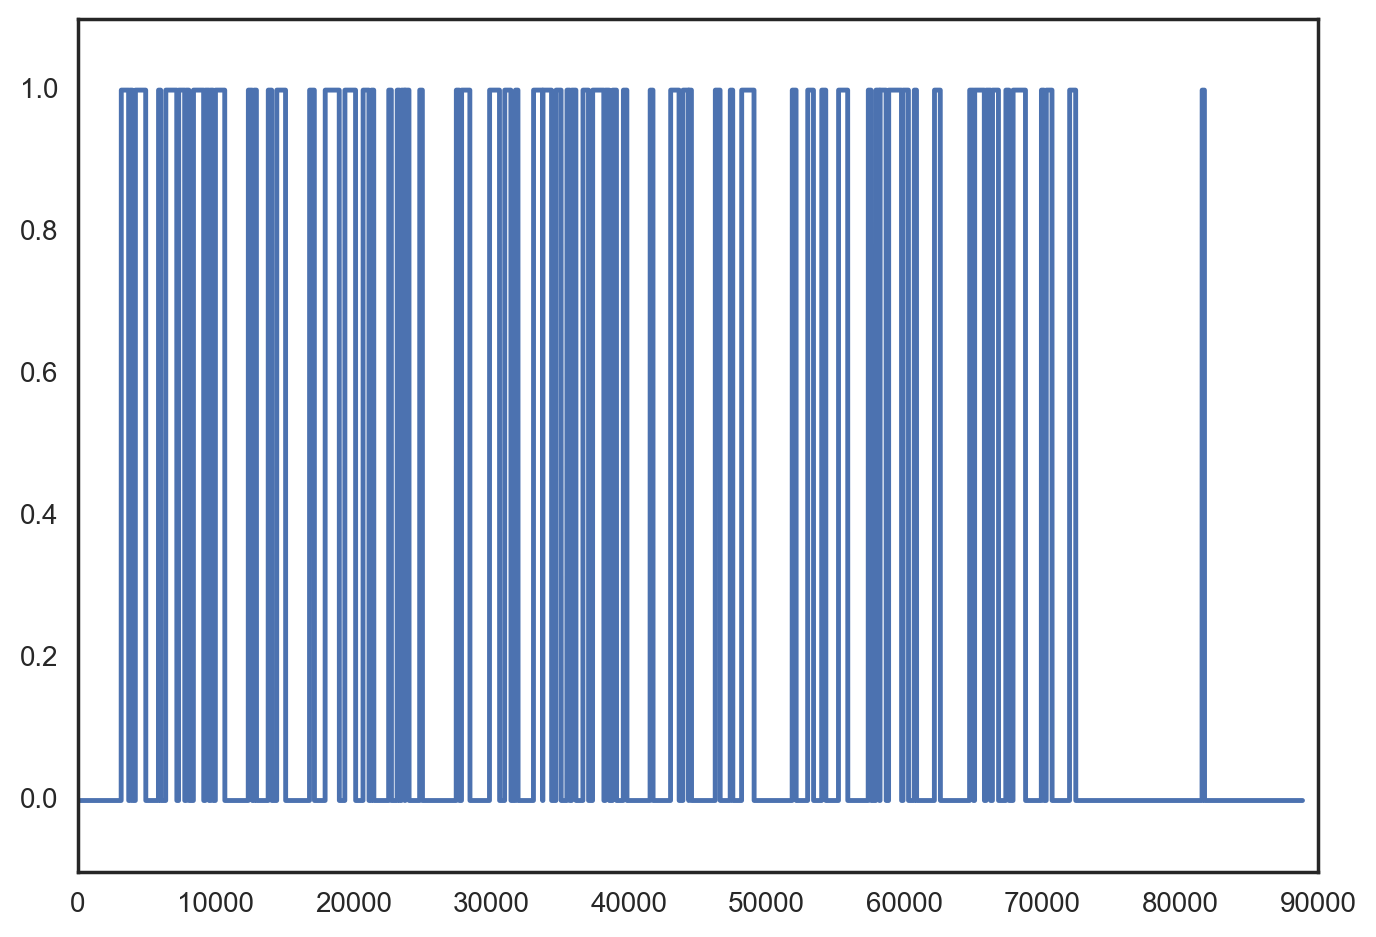

In [18]:
plt.plot(isosc_noshort)
plt.ylim(-.1,1.1)